In [1]:
# !pip install tensorflow==2.16.1 tensorflow-gpu==2.12.0 opencv-python matplotlib

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# for making directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [6]:
# Uncompress tgz labelled faces in the wild dataset
# !tar -xf lfw.tgz

In [7]:
# move all images to negative folder

# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

### Collecting +ve and anchor images

In [4]:
# generating unique image names
import uuid

In [5]:
# generating unique image names
# test code for file name and file path
# os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\57dd3288-1d7f-11ef-ad06-b99221d99787.jpg'

In [6]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video capture.")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[115:365, 195:445, :] # for creating 250*250px image
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

### Preprocessing Images

In [26]:
# pipelines for image directories

anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(350)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(350)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(350)

In [6]:
# function for resizing image

def preprocess(img_path):
    byte_img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [27]:
# creting labelled dataset

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [28]:
# dataloader pipelines

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [29]:
# training partition of dataset

train_data = data.take(round(len(data)*.65))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
# testing partition

test_data = data.skip(round(len(data)*.65))
test_data = test_data.take(round(len(data)*.35))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Building Siamese Neural Network
#### 1. Embedding Layer
#### 2. Distance Layer
#### 3. Siamese Model

In [63]:
inp = Input(shape=(105,105,3), name='input')

In [64]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [65]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [66]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [67]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [74]:
d1

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_70>

In [31]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp] , outputs=[d1] , name='embedding')

In [32]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

#### Distance Layer

In [33]:
# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
#     Similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

In [83]:
l1 = L1Dist()

In [89]:
l1

<L1Dist name=l1_dist_9, built=False>

#### Siamese Model

In [15]:
def make_siamese_model():
    
    input_image = Input(name = 'input', shape=(100,100,3))
    
    validation_image = Input(name='validation', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese')

In [34]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "Siamese"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation (InputLayer)       │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input[0][0],               │
│                               │                           │                 │ validation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Neural Network

#### Loss function

In [35]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [36]:
opt = tf.keras.optimizers.Adam(1e-4)

#### Establishing checkpoints

In [41]:
# os.makedirs('training_checkpoints')
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

#### Build Train Step function

In [37]:
test_batch = train_data.as_numpy_iterator()
len(test_batch.next())

3

In [20]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        X = batch[:2] # anchor and positive/negative images
        y = batch[2] # labels
        
#         forward pass
        yhat = siamese_model(X, training=True)
#         Calculate loss
        loss = binary_cross_loss(y, yhat)
    
    print(loss)
    
#     Calculates derivatives, updates weights and applies the same to the model
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

#### Build training loop

In [21]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for i, batch in enumerate(data):
            train_step(batch)
            progbar.update(i+1)
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

#### Training the Model

In [39]:
EPOCHS = 50

In [42]:
train(train_data, EPOCHS)


 Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step

 Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step

 Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step

 Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

 Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step

 Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1453s 52s/step

 Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 13/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

 Epoch 14/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

 Epoch 15/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

 Epoch 16/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 Epoch 17/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 Epoch 18/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 19/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step

### Making Facial Recognition Predictions

In [43]:
from tensorflow.keras.metrics import Precision, Recall
# metrics used to evaluate the performance of a classification model

In [44]:
# Obtaining test data (test/input image, validation image and label)
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [45]:
# making predictions
y_hat = siamese_model.predict([test_input, test_val])

# Categorizing the predictions by setting thresholds
res = []
for pred in y_hat:
    if pred > 0.5:
        res.append(1)
    else:
        res.append(0)
print('Predictions: ',res)
print('Actual values: ', y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions:  [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
Actual values:  [1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.]


In [46]:
# checks performance of the trained model using tensorflow.keras.metrics.Recall()
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

#### Visualising results (testing purposes)

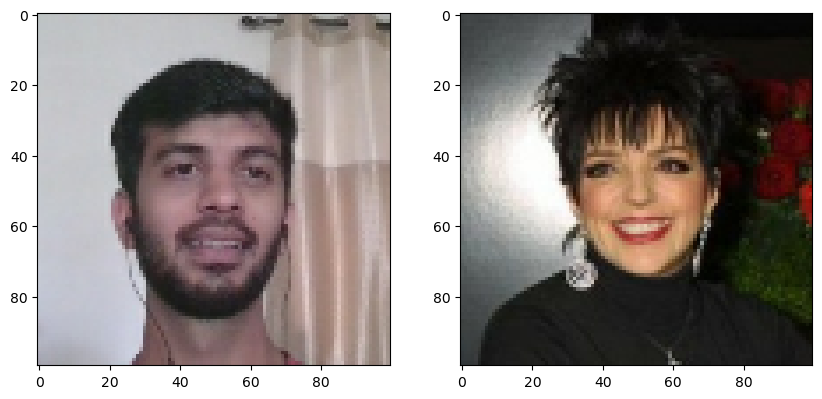

In [47]:
val = 6

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[val])
plt.subplot(1,2,2)
plt.imshow(test_val[val])
plt.show()

### Save Model

In [48]:
# For saving trained model
siamese_model.save('siamesemodel.h5')

In [49]:
# loading model
model = tf.keras.models.load_model('siamesemodel.h5',
                                  custom_objects={'L1Dist':L1Dist, 
                                                  'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [50]:
# making predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[1.0000000e+00],
       [4.3680448e-08],
       [9.9999940e-01],
       [9.9976796e-01],
       [2.3207190e-07],
       [3.6525346e-08],
       [1.6166516e-06],
       [6.8072445e-08],
       [1.8773656e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.2563798e-07],
       [1.0104895e-05],
       [2.0881579e-07],
       [9.9999785e-01],
       [9.9941099e-01]], dtype=float32)

## Real Time Verification

### Verification function

In [51]:
def verify (model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_img')):
        input_image = preprocess(os.path.join('application_data', 'input_img', 'input_img.jpg'))
        validation_image = preprocess(os.path.join('application_data', 'verification_img', image))
        
        result = model.predict(list(np.expand_dims([input_image, validation_image], axis=1)))
        results.append(result)
        
    # Detection
    detection = np.sum(np.array(results) > detection_threshold)

    # verification - number of images passing the detection threshold
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_img')))
    verified = verification > verification_threshold

    return results, verified

### Real time verification

In [52]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[115:365, 195:445, :] # for creating 250*250px image
    
    cv2.imshow('verification',frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_img', 'input_img.jpg'), frame)
        
        # running verification function
        results, verified = verify(model, 0.8, 0.6)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1